In [1208]:
import csv
import pandas as pd
import numpy as np
import math
from scipy.linalg import solve

In [1181]:
# monthly:
df = pd.read_csv("/Users/a7/Desktop/FIN3080/project2/TRD_Mnth.csv")
df = pd.DataFrame(df,columns=["Stkcd","Trdmnt","Mopnprc","Mclsprc","Mretwd","Mnvaltrd"])
df.columns = ["stk","month","open_prc","close_prc","ret","vlm"]

In [1111]:
# daily:
df_1 = pd.read_csv("/Users/a7/Desktop/FIN3080/project2/TRD_Dalyr.csv")
df_2 = pd.read_csv("/Users/a7/Desktop/FIN3080/project2/TRD_Dalyr1.csv")
df_3 = pd.read_csv("/Users/a7/Desktop/FIN3080/project2/TRD_Dalyr2.csv")
df_4 = pd.read_csv("/Users/a7/Desktop/FIN3080/project2/TRD_Dalyr3.csv")
df_5 = pd.read_csv("/Users/a7/Desktop/FIN3080/project2/TRD_Dalyr4.csv")
df_d = pd.concat([df_1,df_2,df_3,df_4,df_5])

In [1182]:
df_daily = pd.DataFrame(df_d,columns=["Stkcd","Trddt","Opnprc","Clsprc","Dretwd","Dnvaltrd"])
df_daily.columns = ["stk","date","open_prc","close_prc","ret","vlm"]
df_daily['month'] = df_daily['date'].apply(lambda x: x[0:7])

In [1113]:
# risk free rate
rf = pd.read_csv("/Users/a7/Desktop/FIN3080/project2/TRD_Nrrate.csv")
rf = pd.DataFrame(rf,columns=['Clsdt','Nrrdata'])
rf.columns = ['date','rf']
rf['rf'] = rf['rf']/100
rf['year'] = rf['date'].apply(lambda x: x[0:4])
rf_year = rf.groupby('year').rf.first()
rf = (rf_year+1).cumprod()[8]**(1/9)-1
rf

0.01970019820040636

In [1114]:
# (1) price
df1 = df
df1['ln_prc'] = df1['close_prc'].apply(lambda x: math.log(x) )
df1 = df1.sort_values(['stk', 'month'], ascending = True)
df1['pre_lnprc'] = df1.groupby('stk')['ln_prc'].shift(1)
df1 = df1.dropna()
df1

,stk,month,open_prc,close_prc,ret,vlm,ln_prc,pre_lnprc
1,600000,2010-02,19.62,20.74,0.057085,1.417428e+10,3.032064,2.976549
2,600000,2010-03,21.00,22.78,0.098361,2.587283e+10,3.125883,3.032064
3,600000,2010-04,22.77,20.59,-0.096137,2.532575e+10,3.024806,3.125883
4,600000,2010-05,20.22,18.54,-0.099563,1.964786e+10,2.919931,3.024806
5,600000,2010-06,18.47,13.60,-0.038355,1.471376e+10,2.610070,2.919931
...,...,...,...,...,...,...,...,...
165637,605598,2021-11,13.62,14.66,0.077941,7.893065e+08,2.685123,2.610070
165638,605598,2021-12,14.72,15.93,0.086630,2.558677e+09,2.768204,2.685123
165640,605599,2021-10,12.74,11.67,-0.080378,9.781484e+08,2.457021,2.540814
165641,605599,2021-11,11.67,12.39,0.061697,8.717006e+08,2.516890,2.457021


In [1115]:
bin_num=4
def gen_bins(rank, max_rank, bin_num):
    res = round((rank/max_rank)*(bin_num))
    return (res)
df1['rank'] = df1.groupby('month')['pre_lnprc'].rank(ascending = False)
df1['count'] = df1.groupby('month')['rank'].transform('count')
df1['bins']  = df1.apply(lambda row: gen_bins(row['rank'], row['count'], bin_num), axis = 1)
df1

,stk,month,open_prc,close_prc,ret,vlm,ln_prc,pre_lnprc,rank,count,bins
1,600000,2010-02,19.62,20.74,0.057085,1.417428e+10,3.032064,2.976549,152.0,850,1
2,600000,2010-03,21.00,22.78,0.098361,2.587283e+10,3.125883,3.032064,149.0,853,1
3,600000,2010-04,22.77,20.59,-0.096137,2.532575e+10,3.024806,3.125883,120.0,858,1
4,600000,2010-05,20.22,18.54,-0.099563,1.964786e+10,2.919931,3.024806,137.0,854,1
5,600000,2010-06,18.47,13.60,-0.038355,1.471376e+10,2.610070,2.919931,132.0,853,1
...,...,...,...,...,...,...,...,...,...,...,...
165637,605598,2021-11,13.62,14.66,0.077941,7.893065e+08,2.685123,2.610070,599.5,1646,1
165638,605598,2021-12,14.72,15.93,0.086630,2.558677e+09,2.768204,2.685123,612.0,1650,1
165640,605599,2021-10,12.74,11.67,-0.080378,9.781484e+08,2.457021,2.540814,659.0,1642,2
165641,605599,2021-11,11.67,12.39,0.061697,8.717006e+08,2.516890,2.457021,712.0,1646,2


In [1116]:
def p_daily(x):
    df_merge = pd.merge(df_daily,x,on=['stk','month'],how='left')
    df_merge = pd.DataFrame(df_merge,columns=["stk","date","month","bins","ret_x"])
    df_merge.columns = ["stk","date","month","bins","ret"]
    df_merge = df_merge.dropna()
    df_merge = df_merge[df_merge.month >= '2013-01']
    return(df_merge)
p1_daily = p_daily(df1)
p1_daily

,stk,date,month,bins,ret
715,600000,2013-01-04,2013-01,1.0,0.010081
716,600000,2013-01-07,2013-01,1.0,0.029940
717,600000,2013-01-08,2013-01,1.0,-0.019380
718,600000,2013-01-09,2013-01,1.0,0.001976
719,600000,2013-01-10,2013-01,1.0,-0.009862
...,...,...,...,...,...
3297807,605599,2021-12-27,2021-12,2.0,0.014937
3297808,605599,2021-12-28,2021-12,2.0,0.001549
3297809,605599,2021-12-29,2021-12,2.0,0.000000
3297810,605599,2021-12-30,2021-12,2.0,0.013921


In [1247]:
def portfolio(x):
    portfolio = x.groupby(["date", "bins"]).mean().reset_index()
    portfolio = pd.pivot_table(portfolio, values = 'ret', columns = 'bins', index = 'date').reset_index()
    portfolio['month'] = portfolio['date'].apply(lambda x: x[0:7])
    portfolio['ret'] = portfolio[4] - portfolio_1[0]
    portfolio['win'] = portfolio.apply(lambda x: 1 if(x.ret > 0) else 0 , axis = 1)
    return(portfolio)
p1 = portfolio(p1_daily)
p1

bins,date,0.0,1.0,2.0,3.0,4.0,month,ret,win
0,2013-01-04,-0.009129,-0.005087,-0.002776,-0.003621,-0.001582,2013-01,-0.001582,0
1,2013-01-07,0.008923,0.011339,0.013010,0.011576,0.005261,2013-01,-0.003661,0
2,2013-01-08,0.015786,0.008645,0.008369,0.007407,0.002527,2013-01,-0.013260,0
3,2013-01-09,0.004511,0.000304,0.000714,0.002833,0.001026,2013-01,-0.003484,0
4,2013-01-10,0.002854,0.004120,0.007051,0.007554,0.005965,2013-01,0.003111,1
...,...,...,...,...,...,...,...,...,...
2183,2021-12-27,0.000827,0.005558,0.005972,0.004764,0.002307,2021-12,0.001480,1
2184,2021-12-28,0.012134,0.003688,0.004395,-0.001049,-0.005087,2021-12,-0.017221,0
2185,2021-12-29,-0.005099,-0.002636,-0.000957,0.000194,-0.001038,2021-12,0.004060,1
2186,2021-12-30,0.007520,0.007492,0.007463,0.008329,0.006290,2021-12,-0.001230,0


In [1118]:
# (2)volume variance
df2 = df
df2['vol_var'] = df2.groupby('stk').vlm.apply(lambda x: x.rolling(window=36).std().shift(1))
df2 = df2.dropna()
df2['rank'] = df2.groupby('month')['vol_var'].rank(ascending = False)
df2['count'] = df2.groupby('month')['rank'].transform('count')
df2['bins']  = df2.apply(lambda row: gen_bins(row['rank'], row['count'], bin_num), axis = 1)
df2

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/3123182064.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['rank'] = df2.groupby('month')['vol_var'].rank(ascending = False)
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/3123182064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['count'] = df2.groupby('month')['rank'].transform('count')
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/3123182064.py:7: SettingWithCopyWarning: 
A value is tryin

,stk,month,open_prc,close_prc,ret,vlm,ln_prc,vol_var,rank,count,bins
36,600000,2013-01,10.10,11.48,0.157258,3.868030e+10,2.440606,8.902156e+09,14.0,735,0
37,600000,2013-02,11.41,11.06,-0.036585,3.313838e+10,2.403335,9.069539e+09,13.0,769,0
38,600000,2013-03,11.07,10.13,-0.084087,3.754377e+10,2.315501,9.480637e+09,13.0,795,0
39,600000,2013-04,10.06,9.88,-0.024679,1.565412e+10,2.290513,9.983078e+09,11.0,808,0
40,600000,2013-05,9.77,10.47,0.059717,1.922743e+10,2.348514,9.888027e+09,12.0,814,0
...,...,...,...,...,...,...,...,...,...,...,...
164313,603999,2021-08,4.85,4.99,0.030992,2.528318e+08,1.607436,7.770757e+08,1029.0,1413,3
164314,603999,2021-09,4.99,4.87,-0.024048,2.758597e+08,1.583094,7.771343e+08,1039.0,1418,3
164315,603999,2021-10,4.91,4.80,-0.014374,1.181106e+08,1.568616,7.734745e+08,1058.0,1417,3
164316,603999,2021-11,4.80,4.85,0.010417,2.253709e+08,1.578979,7.832821e+08,1058.0,1420,3


In [1119]:
p2_daily = p_daily(df2)
p2 = portfolio(p2_daily)

,stk,date,month,bins,ret
715,600000,2013-01-04,2013-01,0.0,0.010081
716,600000,2013-01-07,2013-01,0.0,0.029940
717,600000,2013-01-08,2013-01,0.0,-0.019380
718,600000,2013-01-09,2013-01,0.0,0.001976
719,600000,2013-01-10,2013-01,0.0,-0.009862
...,...,...,...,...,...
3271940,603999,2021-12-27,2021-12,3.0,0.007605
3271941,603999,2021-12-28,2021-12,3.0,-0.003774
3271942,603999,2021-12-29,2021-12,3.0,-0.005682
3271943,603999,2021-12-30,2021-12,3.0,0.040000


In [1250]:
p2

bins,date,0.0,1.0,2.0,3.0,4.0,month,ret,win
0,2013-01-04,0.000000,-0.004076,-0.004822,-0.006079,0.000000,2013-01,0.000000,0
1,2013-01-07,0.003461,0.010806,0.010198,0.010679,0.013005,2013-01,0.004082,1
2,2013-01-08,-0.001731,0.008170,0.010529,0.009383,0.007683,2013-01,-0.008104,0
3,2013-01-09,0.000111,0.000437,0.001879,0.003093,0.002069,2013-01,-0.002442,0
4,2013-01-10,0.007303,0.005318,0.008633,0.004790,0.001615,2013-01,-0.001240,0
...,...,...,...,...,...,...,...,...,...
2183,2021-12-27,-0.001508,-0.001475,0.006045,0.009079,0.009032,2021-12,0.008205,1
2184,2021-12-28,0.006371,0.001200,0.000573,0.002746,0.004984,2021-12,-0.007150,0
2185,2021-12-29,-0.006410,-0.004593,0.001307,0.000834,0.000317,2021-12,0.005415,1
2186,2021-12-30,0.005379,0.007634,0.009260,0.008775,0.003709,2021-12,-0.003811,0


In [1229]:
# (3)liquidity measure
df3 = df_daily
df3["liq_rate"] = df3['ret'].abs() / df3['vlm']
df3.reset_index(drop=True)
s = pd.DataFrame(df3.groupby(['stk'])['liq_rate'].rolling(window=250).mean())
s = s.reset_index(drop=True)
df3['liq_avg'] = s
df3 = df3.dropna()
df3 = df3[df3.date >= '2013-01-01']
df3

,stk,date,open_prc,close_prc,ret,vlm,month,liq_rate,liq_avg
715,600000,2013-01-04,10.10,10.02,0.010081,2.633797e+09,2013-01,3.827554e-12,1.867080e-11
716,600000,2013-01-07,10.05,10.32,0.029940,2.534162e+09,2013-01,1.181456e-11,1.871806e-11
717,600000,2013-01-08,10.34,10.12,-0.019380,1.573240e+09,2013-01,1.231853e-11,1.874376e-11
718,600000,2013-01-09,10.09,10.14,0.001976,1.774560e+09,2013-01,1.113515e-12,1.862672e-11
719,600000,2013-01-10,10.11,10.04,-0.009862,1.224889e+09,2013-01,8.051342e-12,1.860503e-11
...,...,...,...,...,...,...,...,...,...
761879,605599,2021-12-27,12.65,12.91,0.014937,4.338549e+07,2021-12,3.442856e-10,4.539406e-10
761880,605599,2021-12-28,12.91,12.93,0.001549,3.432495e+07,2021-12,4.512753e-11,4.522115e-10
761881,605599,2021-12-29,13.00,12.93,0.000000,4.048105e+07,2021-12,0.000000e+00,4.522258e-10
761882,605599,2021-12-30,12.94,13.11,0.013921,6.039012e+07,2021-12,2.305178e-10,4.500508e-10


In [1230]:
month_avg = pd.DataFrame(df3.groupby(['stk','month']).liq_avg.mean())
month_avg.reset_index(inplace=True)
month_avg.columns = ['stk','month','amihud']
month_avg

,stk,month,amihud
0,600000,2013-01,1.829579e-11
1,600000,2013-02,1.723683e-11
2,600000,2013-03,1.704860e-11
3,600000,2013-04,1.660106e-11
4,600000,2013-05,1.615665e-11
...,...,...,...
122331,605598,2021-12,4.162031e-10
122332,605599,2021-09,4.193553e-10
122333,605599,2021-10,4.511208e-10
122334,605599,2021-11,4.682617e-10


In [1231]:
df3 = pd.merge(df,month_avg,on=['stk','month'],how='left')
df3 = df3.dropna()
df3['rank'] = df3.groupby('month')['amihud'].rank(ascending = False)
df3['count'] = df3.groupby('month')['rank'].transform('count')
df3['bins']  = df3.apply(lambda row: gen_bins(row['rank'], row['count'], bin_num), axis = 1)
df3

,stk,month,open_prc,close_prc,ret,vlm,amihud,rank,count,bins
36,600000,2013-01,10.10,11.48,0.157258,3.868030e+10,1.829579e-11,839.0,859,4
37,600000,2013-02,11.41,11.06,-0.036585,3.313838e+10,1.723683e-11,832.0,852,4
38,600000,2013-03,11.07,10.13,-0.084087,3.754377e+10,1.704860e-11,833.0,852,4
39,600000,2013-04,10.06,9.88,-0.024679,1.565412e+10,1.660106e-11,829.0,846,4
40,600000,2013-05,9.77,10.47,0.059717,1.922743e+10,1.615665e-11,831.0,846,4
...,...,...,...,...,...,...,...,...,...,...
165637,605598,2021-11,13.62,14.66,0.077941,7.893065e+08,4.361363e-10,530.0,1517,1
165638,605598,2021-12,14.72,15.93,0.086630,2.558677e+09,4.162031e-10,554.0,1514,1
165640,605599,2021-10,12.74,11.67,-0.080378,9.781484e+08,4.511208e-10,506.0,1502,1
165641,605599,2021-11,11.67,12.39,0.061697,8.717006e+08,4.682617e-10,492.0,1517,1


In [1232]:
p3_daily = p_daily(df3)
p3_daily

,stk,date,month,bins,ret
715,600000,2013-01-04,2013-01,4.0,0.010081
716,600000,2013-01-07,2013-01,4.0,0.029940
717,600000,2013-01-08,2013-01,4.0,-0.019380
718,600000,2013-01-09,2013-01,4.0,0.001976
719,600000,2013-01-10,2013-01,4.0,-0.009862
...,...,...,...,...,...
3297807,605599,2021-12-27,2021-12,1.0,0.014937
3297808,605599,2021-12-28,2021-12,1.0,0.001549
3297809,605599,2021-12-29,2021-12,1.0,0.000000
3297810,605599,2021-12-30,2021-12,1.0,0.013921


In [1233]:
p3 = portfolio(p3_daily)
p3

bins,date,0.0,1.0,2.0,3.0,4.0,month,ret,win
0,2013-01-04,-0.009617,-0.004157,-0.001205,-0.005023,-0.004382,2013-01,-0.004382,0
1,2013-01-07,0.011362,0.011065,0.010949,0.011047,0.008956,2013-01,0.000034,1
2,2013-01-08,0.009712,0.007716,0.008844,0.009822,0.005638,2013-01,-0.010149,0
3,2013-01-09,0.005173,0.003516,0.001316,-0.000299,0.000144,2013-01,-0.004367,0
4,2013-01-10,0.004315,0.004859,0.007087,0.006390,0.005188,2013-01,0.002334,1
...,...,...,...,...,...,...,...,...,...
2183,2021-12-27,0.004977,0.005031,0.005260,0.002859,0.004173,2021-12,0.003346,1
2184,2021-12-28,0.002124,0.004526,0.001328,0.004185,-0.001636,2021-12,-0.013770,0
2185,2021-12-29,-0.004408,-0.000008,-0.001188,-0.002478,-0.000563,2021-12,0.004535,1
2186,2021-12-30,0.006374,0.007882,0.008174,0.007348,0.009051,2021-12,0.001531,1


In [1126]:
# (4) short-term reversal:
df4 = df
df4['ret_last'] = df4.groupby('stk').ret.shift(1)
df4 = df4.dropna()
df4 = df4[df4.month >= '2013-01']
df4['rank'] = df4.groupby('month')['ret_last'].rank(ascending = False)
df4['count'] = df4.groupby('month')['rank'].transform('count')
df4['bins']  = df4.apply(lambda row: gen_bins(row['rank'], row['count'], bin_num), axis = 1)
df4

,stk,month,open_prc,close_prc,ret,vlm,ln_prc,vol_var,ret_last,rank,count,bins
36,600000,2013-01,10.10,11.48,0.157258,3.868030e+10,2.440606,8.902156e+09,0.329759,33.0,735,0
37,600000,2013-02,11.41,11.06,-0.036585,3.313838e+10,2.403335,9.069539e+09,0.157258,99.0,769,1
38,600000,2013-03,11.07,10.13,-0.084087,3.754377e+10,2.315501,9.480637e+09,-0.036585,690.0,795,3
39,600000,2013-04,10.06,9.88,-0.024679,1.565412e+10,2.290513,9.983078e+09,-0.084087,531.0,808,3
40,600000,2013-05,9.77,10.47,0.059717,1.922743e+10,2.348514,9.888027e+09,-0.024679,324.0,814,2
...,...,...,...,...,...,...,...,...,...,...,...,...
164313,603999,2021-08,4.85,4.99,0.030992,2.528318e+08,1.607436,7.770757e+08,-0.072797,871.0,1413,2
164314,603999,2021-09,4.99,4.87,-0.024048,2.758597e+08,1.583094,7.771343e+08,0.030992,900.0,1418,3
164315,603999,2021-10,4.91,4.80,-0.014374,1.181106e+08,1.568616,7.734745e+08,-0.024048,823.0,1417,2
164316,603999,2021-11,4.80,4.85,0.010417,2.253709e+08,1.578979,7.832821e+08,-0.014374,531.0,1420,1


In [1127]:
p4_daily = p_daily(df4)
p4_daily

,stk,date,month,bins,ret
715,600000,2013-01-04,2013-01,0.0,0.010081
716,600000,2013-01-07,2013-01,0.0,0.029940
717,600000,2013-01-08,2013-01,0.0,-0.019380
718,600000,2013-01-09,2013-01,0.0,0.001976
719,600000,2013-01-10,2013-01,0.0,-0.009862
...,...,...,...,...,...
3271940,603999,2021-12-27,2021-12,3.0,0.007605
3271941,603999,2021-12-28,2021-12,3.0,-0.003774
3271942,603999,2021-12-29,2021-12,3.0,-0.005682
3271943,603999,2021-12-30,2021-12,3.0,0.040000


In [1128]:
p4 = portfolio(p4_daily)
p4

bins,date,0.0,1.0,2.0,3.0,4.0,month,ret,win
0,2013-01-04,-0.007511,-0.004136,-0.004371,-0.002806,-0.002711,2013-01,-0.002711,0
1,2013-01-07,0.007052,0.008551,0.012535,0.011824,0.007068,2013-01,-0.001854,0
2,2013-01-08,0.000006,0.006666,0.011197,0.009785,0.007008,2013-01,-0.008778,0
3,2013-01-09,-0.002442,0.002955,0.001118,0.002712,0.001931,2013-01,-0.002580,0
4,2013-01-10,0.006462,0.005971,0.005578,0.005008,0.006967,2013-01,0.004113,1
...,...,...,...,...,...,...,...,...,...
2183,2021-12-27,-0.001587,0.007026,0.007510,0.003417,0.000477,2021-12,-0.000350,0
2184,2021-12-28,0.008055,0.005766,0.001653,-0.000123,-0.002239,2021-12,-0.014374,0
2185,2021-12-29,-0.001572,0.001745,-0.000956,-0.003619,-0.003714,2021-12,0.001384,1
2186,2021-12-30,0.008358,0.009507,0.009916,0.005092,0.003071,2021-12,-0.004450,0


In [1183]:
# (5)52-week high
df5 = df_daily.sort_values(['stk','date'])
s = pd.DataFrame(df5.groupby('stk').size()>=250)
s.reset_index(inplace=True)
s.columns = ['stk','flag']
df5 = pd.merge(df5,s,on='stk',how='left')
df5 = df5[df5['flag'] == True]
df5['high'] = df5.groupby('stk')['close_prc'].apply(lambda x: x.rolling(window=250).max())
df5 = df5.dropna()
df5

,stk,date,open_prc,close_prc,ret,vlm,month,flag,high
249,600000,2011-01-31,12.70,12.72,0.002364,6.699970e+08,2011-01,True,23.03
250,600000,2011-02-01,12.73,12.76,0.003145,5.320870e+08,2011-02,True,23.03
251,600000,2011-02-09,12.71,12.63,-0.010188,6.403737e+08,2011-02,True,23.03
252,600000,2011-02-10,12.61,12.77,0.011085,6.010938e+08,2011-02,True,23.03
253,600000,2011-02-11,12.75,12.75,-0.001566,1.097944e+09,2011-02,True,23.03
...,...,...,...,...,...,...,...,...,...
3296474,605399,2021-12-29,41.36,41.68,0.004822,1.476591e+08,2021-12,True,53.71
3296475,605399,2021-12-30,41.70,40.65,-0.024712,1.374725e+08,2021-12,True,53.71
3296476,605399,2021-12-31,40.44,39.71,-0.023124,1.426110e+08,2021-12,True,53.71
3297034,605500,2021-12-30,17.87,17.96,0.005036,1.570129e+07,2021-12,True,27.32


In [1184]:
month_high = pd.DataFrame(df5.groupby(['stk','month'])['high'].last())
month_high.reset_index(inplace=True)
month_high

,stk,month,high
0,600000,2011-01,23.03
1,600000,2011-02,23.03
2,600000,2011-03,23.03
3,600000,2011-04,22.88
4,600000,2011-05,19.74
...,...,...,...
145308,605399,2021-09,43.97
145309,605399,2021-10,48.11
145310,605399,2021-11,53.71
145311,605399,2021-12,53.71


In [1186]:
df5 = pd.merge(df,month_high,on=['stk','month'],how='left').dropna()
df5 = pd.merge(df,month_high,on=['stk','month'],how='left').dropna()
df5['ratio'] = df5['close_prc']/df5['high']
df5['pre_ratio'] = df5.groupby('stk')['ratio'].shift(1)
df5 = df5[df5.month >= '2013-01'].dropna()
df5

,stk,month,open_prc,close_prc,ret,vlm,high,ratio,pre_ratio
36,600000,2013-01,10.10,11.48,0.157258,3.868030e+10,11.48,1.000000,1.000000
37,600000,2013-02,11.41,11.06,-0.036585,3.313838e+10,12.07,0.916321,1.000000
38,600000,2013-03,11.07,10.13,-0.084087,3.754377e+10,12.07,0.839271,0.916321
39,600000,2013-04,10.06,9.88,-0.024679,1.565412e+10,12.07,0.818558,0.839271
40,600000,2013-05,9.77,10.47,0.059717,1.922743e+10,12.07,0.867440,0.818558
...,...,...,...,...,...,...,...,...,...
165532,605388,2021-12,17.59,18.19,0.034110,1.834441e+09,29.69,0.612664,0.592455
165568,605399,2021-09,39.23,36.30,-0.078680,5.634839e+09,43.97,0.825563,0.975006
165569,605399,2021-10,36.93,47.22,0.300826,4.317441e+09,48.11,0.981501,0.825563
165570,605399,2021-11,49.70,49.27,0.043414,7.609791e+09,53.71,0.917334,0.981501


In [1187]:
df5['rank'] = df5.groupby('month')['pre_ratio'].rank(ascending = True)
df5['count'] = df5.groupby('month')['rank'].transform('count')
df5['bins']  = df5.apply(lambda row: gen_bins(row['rank'], row['count'], bin_num), axis = 1)
df5

,stk,month,open_prc,close_prc,ret,vlm,high,ratio,pre_ratio,rank,count,bins
36,600000,2013-01,10.10,11.48,0.157258,3.868030e+10,11.48,1.000000,1.000000,889.0,902,4
37,600000,2013-02,11.41,11.06,-0.036585,3.313838e+10,12.07,0.916321,1.000000,887.0,900,4
38,600000,2013-03,11.07,10.13,-0.084087,3.754377e+10,12.07,0.839271,0.916321,711.0,899,3
39,600000,2013-04,10.06,9.88,-0.024679,1.565412e+10,12.07,0.818558,0.839271,641.0,904,3
40,600000,2013-05,9.77,10.47,0.059717,1.922743e+10,12.07,0.867440,0.818558,654.0,906,3
...,...,...,...,...,...,...,...,...,...,...,...,...
165532,605388,2021-12,17.59,18.19,0.034110,1.834441e+09,29.69,0.612664,0.592455,173.0,1552,0
165568,605399,2021-09,39.23,36.30,-0.078680,5.634839e+09,43.97,0.825563,0.975006,1351.0,1526,4
165569,605399,2021-10,36.93,47.22,0.300826,4.317441e+09,48.11,0.981501,0.825563,1071.0,1537,3
165570,605399,2021-11,49.70,49.27,0.043414,7.609791e+09,53.71,0.917334,0.981501,1514.0,1548,4


In [1188]:
p5_daily = p_daily(df5)
p5_daily

,stk,date,month,bins,ret
715,600000,2013-01-04,2013-01,4.0,0.010081
716,600000,2013-01-07,2013-01,4.0,0.029940
717,600000,2013-01-08,2013-01,4.0,-0.019380
718,600000,2013-01-09,2013-01,4.0,0.001976
719,600000,2013-01-10,2013-01,4.0,-0.009862
...,...,...,...,...,...
3296472,605399,2021-12-27,2021-12,3.0,0.017396
3296473,605399,2021-12-28,2021-12,3.0,0.042997
3296474,605399,2021-12-29,2021-12,3.0,0.004822
3296475,605399,2021-12-30,2021-12,3.0,-0.024712


In [1189]:
p5 = portfolio(p5_daily)
p5

bins,date,0.0,1.0,2.0,3.0,4.0,month,ret,win
0,2013-01-04,-0.006262,-0.005293,-0.002623,-0.004733,-0.003449,2013-01,-0.003449,0
1,2013-01-07,0.015350,0.013460,0.010555,0.007763,0.007505,2013-01,-0.001418,0
2,2013-01-08,0.015377,0.010228,0.010418,0.004839,0.000235,2013-01,-0.015551,0
3,2013-01-09,0.009119,0.003779,-0.000380,0.000897,-0.003128,2013-01,-0.007638,0
4,2013-01-10,0.013323,0.006074,0.005845,0.003858,0.001610,2013-01,-0.001245,0
...,...,...,...,...,...,...,...,...,...
2183,2021-12-27,0.010018,0.004194,0.004003,0.003028,0.003611,2021-12,0.002784,1
2184,2021-12-28,0.003961,0.001196,0.001547,0.002727,0.007627,2021-12,-0.004507,0
2185,2021-12-29,-0.004491,-0.004509,-0.000498,0.002087,-0.001165,2021-12,0.003933,1
2186,2021-12-30,0.005731,0.005724,0.007090,0.010135,0.008752,2021-12,0.001232,1


In [1136]:
# (6)max
df6 = df_daily
df6['month'] = df6['date'].apply(lambda x: x[0:7])
month_max = df6.groupby(['stk','month']).ret.max()
month_max = pd.DataFrame(month_max)
month_max.reset_index(inplace=True)
month_max.columns = ['stk','month','m_max']
month_max

,stk,month,m_max
0,600000,2010-01,0.034361
1,600000,2010-02,0.054934
2,600000,2010-03,0.032345
3,600000,2010-04,0.026750
4,600000,2010-05,0.036977
...,...,...,...
165638,605598,2021-12,0.100275
165639,605599,2021-09,0.440000
165640,605599,2021-10,0.034691
165641,605599,2021-11,0.026556


In [1137]:
df6 = pd.merge(df,month_max,on=['stk','month'],how='left')
df6['pre_max'] = df6.groupby('stk').m_max.shift(1)
df6 = df6.dropna()
df6['rank'] = df6.groupby('month')['pre_max'].rank(ascending = False)
df6['count'] = df6.groupby('month')['rank'].transform('count')
df6['bins']  = df6.apply(lambda row: gen_bins(row['rank'], row['count'], bin_num), axis = 1)
df6

,stk,month,open_prc,close_prc,ret,vlm,m_max,pre_max,rank,count,bins
1,600000,2010-02,19.62,20.74,0.057085,1.417428e+10,0.054934,0.034361,641.0,850,3
2,600000,2010-03,21.00,22.78,0.098361,2.587283e+10,0.032345,0.054934,223.0,853,1
3,600000,2010-04,22.77,20.59,-0.096137,2.532575e+10,0.026750,0.032345,624.0,858,3
4,600000,2010-05,20.22,18.54,-0.099563,1.964786e+10,0.036977,0.026750,715.0,854,3
5,600000,2010-06,18.47,13.60,-0.038355,1.471376e+10,0.063218,0.036977,753.0,853,4
...,...,...,...,...,...,...,...,...,...,...,...
165637,605598,2021-11,13.62,14.66,0.077941,7.893065e+08,0.031528,0.040237,894.0,1646,2
165638,605598,2021-12,14.72,15.93,0.086630,2.558677e+09,0.100275,0.031528,1190.0,1650,3
165640,605599,2021-10,12.74,11.67,-0.080378,9.781484e+08,0.034691,0.440000,2.0,1642,0
165641,605599,2021-11,11.67,12.39,0.061697,8.717006e+08,0.026556,0.034691,1029.0,1646,3


In [1138]:
p6_daily = p_daily(df6)
p6_daily

,stk,date,month,bins,ret
715,600000,2013-01-04,2013-01,1.0,0.010081
716,600000,2013-01-07,2013-01,1.0,0.029940
717,600000,2013-01-08,2013-01,1.0,-0.019380
718,600000,2013-01-09,2013-01,1.0,0.001976
719,600000,2013-01-10,2013-01,1.0,-0.009862
...,...,...,...,...,...
3297807,605599,2021-12-27,2021-12,3.0,0.014937
3297808,605599,2021-12-28,2021-12,3.0,0.001549
3297809,605599,2021-12-29,2021-12,3.0,0.000000
3297810,605599,2021-12-30,2021-12,3.0,0.013921


In [1139]:
p6 = portfolio(p6_daily)
p6

bins,date,0.0,1.0,2.0,3.0,4.0,month,ret,win
0,2013-01-04,-0.000516,-0.005056,-0.005719,-0.003841,-0.003959,2013-01,-0.003959,0
1,2013-01-07,0.011664,0.010179,0.012124,0.010504,0.008647,2013-01,-0.000276,0
2,2013-01-08,0.007348,0.005254,0.010579,0.010346,0.007469,2013-01,-0.008318,0
3,2013-01-09,-0.003889,0.003281,0.002617,0.002008,0.001358,2013-01,-0.003153,0
4,2013-01-10,0.004402,0.005591,0.007286,0.005802,0.004529,2013-01,0.001675,1
...,...,...,...,...,...,...,...,...,...
2183,2021-12-27,0.004438,0.002207,0.002669,0.007431,0.006650,2021-12,0.005823,1
2184,2021-12-28,0.004137,0.004330,0.002027,0.003035,-0.001819,2021-12,-0.013954,0
2185,2021-12-29,-0.001795,-0.003327,-0.001265,-0.000263,-0.001431,2021-12,0.003668,1
2186,2021-12-30,0.006047,0.006563,0.009251,0.007748,0.007190,2021-12,-0.000331,0


In [1251]:
def p_cumret(x):
    p_cumret = x['ret']; p_cumret[0] = 0; p_cumret = (p_cumret+1).cumprod()
    return(p_cumret)
p1_cumret = p_cumret(p1); p2_cumret = p_cumret(p2); p3_cumret = p_cumret(p3)
p4_cumret = p_cumret(p4); p5_cumret = p_cumret(p5); p6_cumret = p_cumret(p6)

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/2289358397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_cumret = x['ret']; p_cumret[0] = 0; p_cumret = (p_cumret+1).cumprod()


In [1252]:
# annual_return, annual_volatility, sharpe_ratio, winning_rate, max_drag_down
ret1 = (p1_cumret[2187])**(1/9)-1; ret2 = (p2_cumret[2187])**(1/9)-1
ret3 = (p3_cumret[2187])**(1/9)-1; ret4 = (p4_cumret[2187])**(1/9)-1
ret5 = (p5_cumret[2187])**(1/9)-1; ret6 = (p6_cumret[2187])**(1/9)-1
annual_ret = [ret1,ret2,ret3,ret4,ret5,ret6]
annual_ret = pd.DataFrame(annual_ret).T
annual_ret.columns = ['Strategy-1','Strategy-2','Strategy-3','Strategy-4','Strategy-5','Strategy-6']

In [1253]:
vol1 = p1['ret'].std()*(252**0.5); vol2 = p2['ret'].std()*(252**0.5)
vol3 = p3['ret'].std()*(252**0.5); vol4 = p4['ret'].std()*(252**0.5)
vol5 = p5['ret'].std()*(252**0.5); vol6 = p6['ret'].std()*(252**0.5)
annual_vol = [vol1,vol2,vol3,vol4,vol5,vol6]
annual_vol = pd.DataFrame(annual_vol).T
annual_vol.columns = ['Strategy-1','Strategy-2','Strategy-3','Strategy-4','Strategy-5','Strategy-6']

In [1254]:
sp1 = (ret1-rf)/vol1; sp2 = (ret2-rf)/vol2; sp3 = (ret3-rf)/vol3
sp4 = (ret4-rf)/vol4; sp5 = (ret5-rf)/vol5; sp6 = (ret6-rf)/vol6
sharpe_ratio = [sp1,sp2,sp3,sp4,sp5,sp6]
sharpe_ratio = pd.DataFrame(sharpe_ratio).T
sharpe_ratio.columns = ['Strategy-1','Strategy-2','Strategy-3','Strategy-4','Strategy-5','Strategy-6']

In [1255]:
win1 = p1['win'].sum()/2188; win2 = p2['win'].sum()/2188; win3 = p3['win'].sum()/2188
win4 = p4['win'].sum()/2188; win5 = p5['win'].sum()/1856; win6 = p6['win'].sum()/2188
winning_rate = [win1,win2,win3,win4,win5,win6]
winning_rate = pd.DataFrame(winning_rate).T
winning_rate.columns = ['Strategy-1','Strategy-2','Strategy-3','Strategy-4','Strategy-5','Strategy-6']

In [1256]:
mdd1 = (p1['ret'].max()-p1['ret'].min())/p1['ret'].max()
mdd2 = (p2['ret'].max()-p2['ret'].min())/p2['ret'].max()
mdd3 = (p3['ret'].max()-p3['ret'].min())/p3['ret'].max()
mdd4 = (p4['ret'].max()-p4['ret'].min())/p4['ret'].max()
mdd5 = (p5['ret'].max()-p5['ret'].min())/p5['ret'].max()
mdd6 = (p6['ret'].max()-p6['ret'].min())/p6['ret'].max()
mdd = [mdd1,mdd2,mdd3,mdd4,mdd5,mdd6]
mdd = pd.DataFrame(mdd).T
mdd.columns = ['Strategy-1','Strategy-2','Strategy-3','Strategy-4','Strategy-5','Strategy-6']

In [1257]:
df_all = pd.concat([annual_ret,annual_vol,sharpe_ratio,winning_rate,mdd]).T
df_all.columns=['annual_ret','annual_vol','sharpe_ratio','winning_rate','max_drag_down']
df_all

,annual_ret,annual_vol,sharpe_ratio,winning_rate,max_drag_down
Strategy-1,0.098384,0.178106,0.441784,0.478062,1.769634
Strategy-2,0.142936,0.134616,0.915465,0.513711,2.071459
Strategy-3,0.035954,0.118034,0.137706,0.501371,1.651849
Strategy-4,0.044068,0.139062,0.175229,0.496344,1.793254
Strategy-5,0.024360,0.135363,0.034425,0.594828,2.275121
Strategy-6,0.013071,0.150311,-0.044103,0.474863,1.714920


Text(0.5, 1.0, 'Annualized Return')

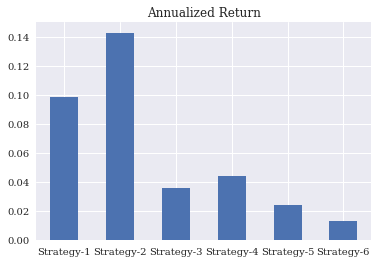

In [1264]:
df_all['annual_ret'].plot.bar(rot=0)
plt.title("Annualized Return")

Text(0.5, 1.0, 'Annualized Volatility')

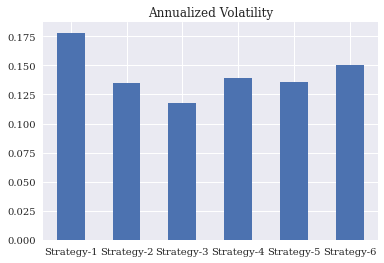

In [1265]:
df_all['annual_vol'].plot.bar(rot=0)
plt.title("Annualized Volatility")

Text(0.5, 1.0, 'Winning Rate')

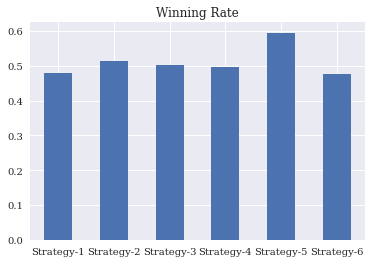

In [1268]:
df_all['winning_rate'].plot.bar(rot=0)
plt.title("Winning Rate")

Text(0.5, 1.0, 'Sharpe Ratio')

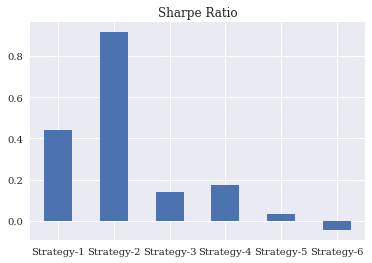

In [1269]:
df_all['sharpe_ratio'].plot.bar(rot=0)
plt.title("Sharpe Ratio")

Text(0.5, 1.0, 'Maximum Drawn Down')

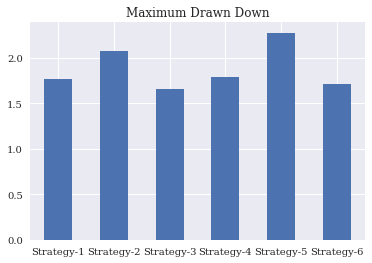

In [1271]:
df_all['max_drag_down'].plot.bar(rot=0)
plt.title("Maximum Drawn Down")

In [1285]:
# b.
def gen_long_short(x):
    long = x[4]; long[0] = 0; long = (long+1).cumprod()
    annual_long = (long[len(long)-1])**(1/9)-1
    short = x[0]; short[0] = 0; short = (short+1).cumprod()
    annual_short = (short[len(short)-1])**(1/9)-1
    s = [annual_long, annual_short]
    s = pd.DataFrame(s)
    return (s)
def gen_long(x):
    long = x[4]; long[0] = 0; long = (long+1).cumprod()
    return(long)
def gen_short(x):
    short = x[0]; short[0] = 0; short = (short+1).cumprod()
    return(short)

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/1598369670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long = x[4]; long[0] = 0; long = (long+1).cumprod()
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/1598369670.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short = x[0]; short[0] = 0; short = (short+1).cumprod()


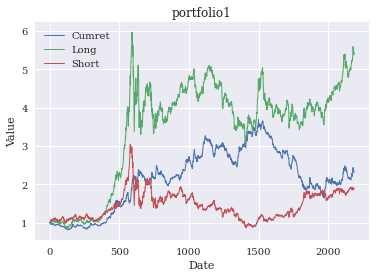

In [1289]:
p1_long = gen_long(p1)
p1_short = gen_short(p1)
plt.plot(p1_cumret,linewidth=1,label='Cumret')
plt.plot(p1_long,linewidth=1,label='Long')
plt.plot(p1_short,linewidth=1,label='Short')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("portfolio1")
plt.legend()
plt.show()

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/1598369670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long = x[4]; long[0] = 0; long = (long+1).cumprod()
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/1598369670.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short = x[0]; short[0] = 0; short = (short+1).cumprod()


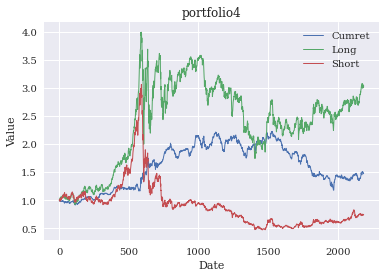

In [1287]:
p4_long = gen_long(p4)
p4_short = gen_short(p4)
plt.plot(p4_cumret,linewidth=1,label='Cumret')
plt.plot(p4_long,linewidth=1,label='Long')
plt.plot(p4_short,linewidth=1,label='Short')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("portfolio4")
plt.legend()
plt.show()

In [1273]:
s1 = gen_long_short(p1); s2 = gen_long_short(p2); s3 = gen_long_short(p3)
s4 = gen_long_short(p4); s5 = gen_long_short(p5); s6 = gen_long_short(p6)
s_all = pd.DataFrame(pd.concat([s1,s2,s3,s4,s5,s6],axis=1))
s_all.columns = ['Strategy-1','Strategy-2','Strategy-3','Strategy-4','Strategy-5','Strategy-6']
s_all = s_all.T
s_all.columns = ['long_ret','short_ret']
df_all = pd.concat([df_all,s_all],axis=1)
df_all

/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/481585494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long = x[4]; long[0] = 0; long = (long+1).cumprod()
/var/folders/lt/n310_nl560b_6_l958v677f40000gn/T/ipykernel_19556/481585494.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short = x[0]; short[0] = 0; short = (short+1).cumprod()


,annual_ret,annual_vol,sharpe_ratio,winning_rate,max_drag_down,long_ret,short_ret
Strategy-1,0.098384,0.178106,0.441784,0.478062,1.769634,0.207461,0.074592
Strategy-2,0.142936,0.134616,0.915465,0.513711,2.071459,0.247098,0.027382
Strategy-3,0.035954,0.118034,0.137706,0.501371,1.651849,0.127899,0.155697
Strategy-4,0.044068,0.139062,0.175229,0.496344,1.793254,0.131517,-0.032088
Strategy-5,0.024360,0.135363,0.034425,0.594828,2.275121,0.118328,0.110938
Strategy-6,0.013071,0.150311,-0.044103,0.474863,1.714920,0.117568,0.095113


In [1274]:
A1 = np.array(df_all['long_ret'])
A2 = np.array(df_all['short_ret'])
B = np.array(df_all['annual_ret'])
result = []
for i in range(len(A1)):
    temp = solve(np.array([[A1[i],-A2[i]],[1,1]]),np.array([B[i],1]))
    result.append(temp)
result = pd.DataFrame(result)
result.columns = ['long_wgt','short_wgt']
result = result.T
result.columns = ['Strategy-1','Strategy-2','Strategy-3','Strategy-4','Strategy-5','Strategy-6']
result = result.T
df_all = pd.concat([df_all,result],axis=1)
df_all

,annual_ret,annual_vol,sharpe_ratio,winning_rate,max_drag_down,long_ret,short_ret,long_wgt,short_wgt
Strategy-1,0.098384,0.178106,0.441784,0.478062,1.769634,0.207461,0.074592,0.613275,0.386725
Strategy-2,0.142936,0.134616,0.915465,0.513711,2.071459,0.247098,0.027382,0.620511,0.379489
Strategy-3,0.035954,0.118034,0.137706,0.501371,1.651849,0.127899,0.155697,0.675789,0.324211
Strategy-4,0.044068,0.139062,0.175229,0.496344,1.793254,0.131517,-0.032088,0.120485,0.879515
Strategy-5,0.024360,0.135363,0.034425,0.594828,2.275121,0.118328,0.110938,0.590137,0.409863
Strategy-6,0.013071,0.150311,-0.044103,0.474863,1.714920,0.117568,0.095113,0.508667,0.491333


In [1153]:
# c. plot the net-value curve
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('seaborn')
mpl.rcParams['font.family']='serif'
%matplotlib inline

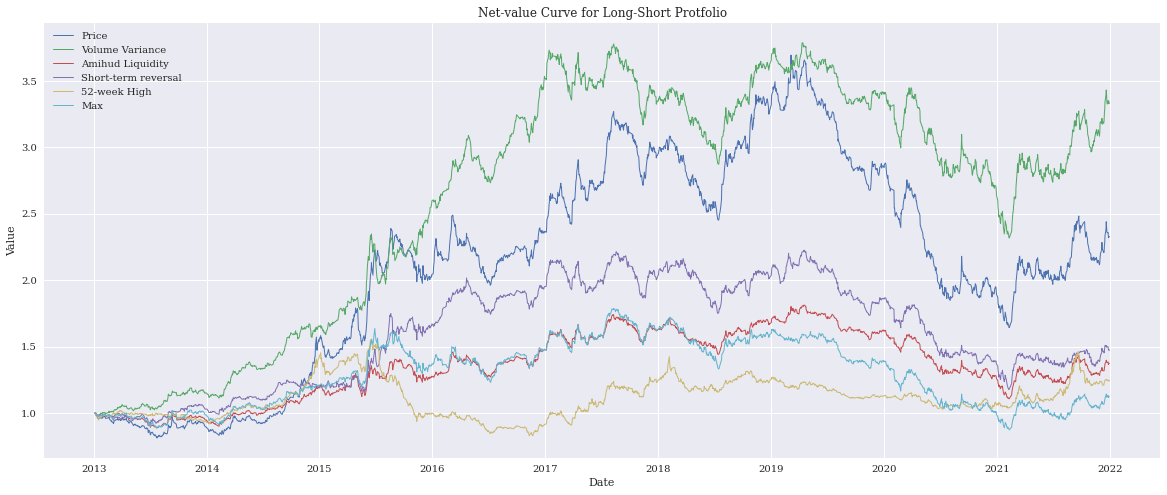

In [1241]:
d = pd.to_datetime(p1.date,format='%Y-%m-%d')
plt.figure(1,figsize=[20,8])
plt.plot(d,p1_cumret,linewidth=1,label='Price')
plt.plot(d,p2_cumret,linewidth=1,label='Volume Variance')
plt.plot(d,p3_cumret,linewidth=1,label='Amihud Liquidity')
plt.plot(d,p4_cumret,linewidth=1,label='Short-term reversal')
plt.plot(d,p5_cumret,linewidth=1,label='52-week High')
plt.plot(d,p6_cumret,linewidth=1,label='Max')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title("Net-value Curve for Long-Short Protfolio")
plt.legend()
plt.show()